<a href="https://colab.research.google.com/github/riddhixraina/rrp4822_Riddhi_ML_Lab2/blob/main/lab2_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Acknowledgement

This lab is imported from prof. Christopher Musco's 2024 iteration of CS-GY 6923. Thanks Chris!

# Lab:  Model Order Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain.  In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces (see. e.g. https://www.youtube.com/watch?v=QRt8QCx3BCo).  In this lab, you will use model selection for performing some simple analysis on real neural signals.  

Before doing this lab, you should review the ideas in the polynomial model selection demo.  In addition to the concepts in that demo, you will learn to:
* Represent neural time-series data in arrays
* Load data from a pickle file
* Describe and fit memoryless linear models
* Describe and fit linear time-series models with delays
* Fit linear models with multiple target outputs
* Select the optimal delay via cross-validation

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="https://pubmed.ncbi.nlm.nih.gov/21613593/">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex. Being able to make such predictions is the precursor to [technologies like Braingate and Neuralink](https://www.youtube.com/watch?v=QRt8QCx3BCo) that use electrode implants to read neural activity that then controls a cursor or robotic arm.

We first load the key packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of datasets and can be used for projects as well.  However, the raw data files can be quite large.  To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data.  You can download the file `example_data_s1.pickle` from [this link](https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true).  Alternatively, you can directly run the following code.

In [2]:
fn_src = 'https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


The file is a *pickle* data structure, which is a package to serialize python objects into data files.  Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.
The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction
* `y[i,1] = ` velocity of the monkey's hand in the y-direction

Our goal will be to predict **only** `y[i,0]` from `X`. We could just as easily predict movement in both directions, but this simplifies the lab.  So we reassign:

In [4]:
y = y[:,0]

Each time bin represent `tsamp=0.05` seconds of time.  Using `X.shape` and `y.shape` compute and print:
* `nt = ` the total number of time bins
* `nneuron = ` the total number of neurons
* `ttotal = ` total time of the experiment is seconds.

In [5]:
tsamp = 0.05  # sampling time in seconds

# TODO
# nt = ...
# nneuron = ..
# ttotal = ...
nt = X.shape[0]
nneuron = X.shape[1]
ttotal = nt * tsamp

print(f"Total number of time bins (nt): {nt}")
print(f"Total number of neurons (nneuron): {nneuron}")
print(f"Total time of the experiment (ttotal): {ttotal:.2f} seconds")

Total number of time bins (nt): 61339
Total number of neurons (nneuron): 52
Total time of the experiment (ttotal): 3066.95 seconds


## Fitting a Memoryless Linear Model

Let's first try a simple linear regression model to fit the data.

Before doing so, we want to split the data into a training and test set. We will use a 2/3 - 1/3 split, so 1/3 of the data should be used for testing.

Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set. Recall that `ytr` and `yts` should be taken from the *first column of `y` only*. You can use any utility to perform the split that you want, but make sure that it is *random*. I.e. don't just take the first rows of the data to be the training data. `np.random.permutation` might come in handy.

In [6]:
# TODO Xtr, Xts, ytr, yts = ... %% [markdown] Next, write an function that, fits
# a linear model given a predictor matrix X and a vector of target values y.
# Your function should find the optimal beta to minimize the squared loss. You
# should do so using the matrix equations discussed in class -- do not use any
# built in functions from e.g. Scikit Learn.
# TODO: Split data into training and test sets
# Get the total number of samples
nt = X.shape[0]

# Create a random permutation of indices
indices = np.random.permutation(nt)

# Calculate the split point for a 2/3 training set
split_idx = int(np.floor(2/3 * nt))

# Use the permuted indices to create the splits
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

Xtr, ytr = X[train_indices,:], y[train_indices]
Xts, yts = X[test_indices,:], y[test_indices]

print(f"X training shape: {Xtr.shape}")
print(f"y training shape: {ytr.shape}")
print(f"X test shape: {Xts.shape}")
print(f"y test shape: {yts.shape}")

X training shape: (40892, 52)
y training shape: (40892,)
X test shape: (20447, 52)
y test shape: (20447,)


Next, write an function that, fits a linear model given a predictor matrix X and a vector of target values y. Your function should find the optimal beta to minimize the squared loss. You should do so using the matrix equations discussed in class -- do not use any built in functions from e.g. Scikit Learn.

 Your linear model should have an intercept (a column of all oness). Hint: You might want to use numpy's concatenate function and the ones function.

In [7]:
def fit_mult_linear(X,y):
    """
    Given matrix of predictors X and target vector y fit for a multiple linear regression model under the squared loss.
    """
    # TODO complete the following code
    # Add a column of ones to the beginning of X for the intercept term
    X_aug = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    # Calculate beta using the normal equation: beta = (X^T*X)^-1 * X^T*y
    # We use the pseudo-inverse (pinv) for better numerical stability.
    # beta = ...
    beta = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ y

    return beta

Now, use your function to fit a multiple linear regression model under squared loss using `Xtr,ytr`.
Make predictions  `yhat` using `Xts`.

In [8]:
# TODO yhat = ... %% [markdown] Compare `yhat` to `yts` to measure the
# **averaged squared loss** (empirical risk) on the test set. Print the output.
# You should obtain an average loss of around 32 or 33 if you are normalizing by
# 1/(test set size). %% TODO loss = %% [markdown] It is useful to plot the
# predicted vs. true values. Plot `yhat` vs. `yts` with a scatter plot and label
# the axes. If the predicted values exactly matched the targets, we would expect
# to see a line with slope 1. %% TODO %% [markdown] ## Fitting Models with Delay
#
# One way we can improve the model accuracy is to used delayed version of the
# features. Specifically, the model we used above mapped the features
#
# $$ \hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0 $$ where $p$ is the
# number of features and $\beta$ is our vector of coefficients. In this model,
# $\hat{y}_i$ at time $i$ was only dependent on the inputs $X_{i,1,\ldots,p}$ at
# time $i$. In signal processing, this is called a *memoryless* model. However,
# in many physical systems, such as those that arise in neuroscience, there is a
# delay between the inputs $X_{i,1,\ldots,p}$ and the outputs $y_i$. For such
# cases, we can use a model of the form,
#
# $$ \hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} +
# \beta_{0,m} $$
#
# where $\beta$ is now a 2-dim array of coefficients where $\beta_{j,m}$ is the
# influence of the input $X_{i+m,j}$ onto output $y_{i+d}$
#
# In signal processing, this model is called an *FIR* filter. The point is that
# the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.
# Hence, it depends on the last `d+1` time steps, not just the most recent time.
#
# To translate this into a linear regression problem, complete the following
# function that creates a new feature and target matrix where: %% [markdown]
# Compare `yhat` to `yts` to measure the **averaged squared loss** (empirical
# risk) on the test set. Print the output. You should obtain an average loss of
# around 32 or 33 if you are normalizing by 1/(test set size). %% TODO loss = %%
# [markdown] It is useful to plot the predicted vs. true values. Plot `yhat` vs.
# `yts` with a scatter plot and label the axes. If the predicted values exactly
# matched the targets, we would expect to see a line with slope 1. %% TODO %%
# [markdown] ## Fitting Models with Delay
#
# One way we can improve the model accuracy is to used delayed version of the
# features. Specifically, the model we used above mapped the features
#
# $$ \hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0 $$ where $p$ is the
# number of features and $\beta$ is our vector of coefficients. In this model,
# $\hat{y}_i$ at time $i$ was only dependent on the inputs $X_{i,1,\ldots,p}$ at
# time $i$. In signal processing, this is called a *memoryless* model. However,
# in many physical systems, such as those that arise in neuroscience, there is a
# delay between the inputs $X_{i,1,\ldots,p}$ and the outputs $y_i$. For such
# cases, we can use a model of the form,
#
# $$ \hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} +
# \beta_{0,m} $$
#
# where $\beta$ is now a 2-dim array of coefficients where $\beta_{j,m}$ is the
# influence of the input $X_{i+m,j}$ onto output $y_{i+d}$
#
# In signal processing, this model is called an *FIR* filter. The point is that
# the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.
# Hence, it depends on the last `d+1` time steps, not just the most recent time.
#
# To translate this into a linear regression problem, complete the following
# function that creates a new feature and target matrix where:

# Fit the model on the training data to get the coefficients
beta = fit_mult_linear(Xtr, ytr)

# Add an intercept column to the test features
Xts_aug = np.concatenate((np.ones((Xts.shape[0], 1)), Xts), axis=1)

# Make predictions on the test data
yhat = Xts_aug @ beta

print(f"Successfully generated {len(yhat)} predictions.")

Successfully generated 20447 predictions.


Compare `yhat` to `yts` to measure the **averaged squared loss** (empirical risk) on the test set. Print the output. You should obtain an average loss of around 32 or 33 if you are normalizing by 1/(test set size).

In [9]:
# TODO loss = %% [markdown] It is useful to plot the predicted vs. true values.
# Plot `yhat` vs. `yts` with a scatter plot and label the axes. If the predicted
# values exactly matched the targets, we would expect to see a line with slope
# 1. %% TODO %% [markdown] ## Fitting Models with Delay
#
# One way we can improve the model accuracy is to used delayed version of the
# features. Specifically, the model we used above mapped the features
#
# $$ \hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0 $$ where $p$ is the
# number of features and $\beta$ is our vector of coefficients. In this model,
# $\hat{y}_i$ at time $i$ was only dependent on the inputs $X_{i,1,\ldots,p}$ at
# time $i$. In signal processing, this is called a *memoryless* model. However,
# in many physical systems, such as those that arise in neuroscience, there is a
# delay between the inputs $X_{i,1,\ldots,p}$ and the outputs $y_i$. For such
# cases, we can use a model of the form,
#
# $$ \hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} +
# \beta_{0,m} $$
#
# where $\beta$ is now a 2-dim array of coefficients where $\beta_{j,m}$ is the
# influence of the input $X_{i+m,j}$ onto output $y_{i+d}$
#
# In signal processing, this model is called an *FIR* filter. The point is that
# the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.
# Hence, it depends on the last `d+1` time steps, not just the most recent time.
#
# To translate this into a linear regression problem, complete the following
# function that creates a new feature and target matrix where:
# TODO: Calculate the average squared loss
loss = np.mean((yts - yhat)**2)

print(f"Averaged squared loss on the test set: {loss:.4f}")

Averaged squared loss on the test set: 32.1479


It is useful to plot the predicted vs. true values. Plot `yhat` vs. `yts` with a scatter plot and label the axes. If the predicted values exactly matched the targets, we would expect to see a line with slope 1.

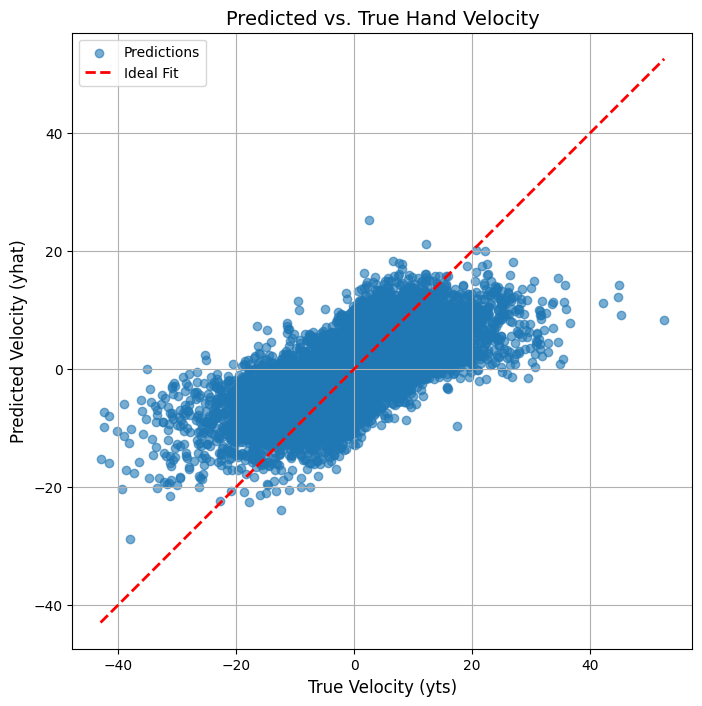

In [10]:
# TODO %% [markdown] ## Fitting Models with Delay
#
# One way we can improve the model accuracy is to used delayed version of the
# features. Specifically, the model we used above mapped the features
#
# $$ \hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0 $$ where $p$ is the
# number of features and $\beta$ is our vector of coefficients. In this model,
# $\hat{y}_i$ at time $i$ was only dependent on the inputs $X_{i,1,\ldots,p}$ at
# time $i$. In signal processing, this is called a *memoryless* model. However,
# in many physical systems, such as those that arise in neuroscience, there is a
# delay between the inputs $X_{i,1,\ldots,p}$ and the outputs $y_i$. For such
# cases, we can use a model of the form,
#
# $$ \hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} +
# \beta_{0,m} $$
#
# where $\beta$ is now a 2-dim array of coefficients where $\beta_{j,m}$ is the
# influence of the input $X_{i+m,j}$ onto output $y_{i+d}$
#
# In signal processing, this model is called an *FIR* filter. The point is that
# the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.
# Hence, it depends on the last `d+1` time steps, not just the most recent time.
#
# To translate this into a linear regression problem, complete the following
# function that creates a new feature and target matrix where:

# TODO: Plot yhat vs. yts
plt.figure(figsize=(8, 8))
plt.scatter(yts, yhat, alpha=0.6, label='Predictions')

# Add the ideal y=x line for reference
min_val = min(np.min(yts), np.min(yhat))
max_val = max(np.max(yts), np.max(yhat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit')

# Labeling
plt.xlabel("True Velocity (yts)", fontsize=12)
plt.ylabel("Predicted Velocity (yhat)", fontsize=12)
plt.title("Predicted vs. True Hand Velocity", fontsize=14)
plt.grid(True)
plt.axis('equal') # Ensure the x and y axes have the same scale
plt.legend()
plt.show()

## Fitting Models with Delay

One way we can improve the model accuracy is to used delayed version of the features.  Specifically, the model we used above mapped the features

$$
\hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0
$$
where $p$ is the number of features and $\beta$ is our vector of coefficients.  In this model,  $\hat{y}_i$ at time $i$ was only dependent on the inputs  $X_{i,1,\ldots,p}$ at time $i$.  In signal processing, this is called a *memoryless* model.  However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs $X_{i,1,\ldots,p}$ and the outputs $y_i$.  For such cases, we can use a model of the form,

$$
\hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} + \beta_{0,m}
$$
    
where $\beta$ is now a 2-dim array of coefficients where $\beta_{j,m}$ is the influence of the input $X_{i+m,j}$ onto output $y_{i+d}$


In signal processing, this model is called an *FIR* filter.  The point is that the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.  Hence, it depends on the last `d+1` time steps, not just the most recent time.

To translate this into a linear regression problem, complete the following function that creates a new feature and target matrix where:

    Xdly[i,:] is the concatenation of the vectors X[i,:], X[i+1,:], ..., X[i+d,:]
    ydly[i,:] = y[i+d,:]
    
Note that if `X` is `n x p` then `Xdly` will be `n-d x (d+1)*p`.  


In [11]:
import numpy as np

def create_dly_data(X, y, d):
    """
    Transforms time-series data to incorporate delays for an FIR-type model.

    For each time step i, the new feature vector is a concatenation of the original
    features from time i to i+d. The new target is the original target at time i+d.

    Args:
        X (np.ndarray): The original feature matrix of shape (n_samples, n_features).
        y (np.ndarray): The original target vector of shape (n_samples,).
        d (int): The number of delay steps to include.

    Returns:
        tuple: A tuple containing:
            - Xdly (np.ndarray): The transformed feature matrix of shape
              (n_samples-d, n_features * (d+1)).
            - ydly (np.ndarray): The transformed target vector of shape (n_samples-d,).
    """
    # TODO
    # Get the number of samples (time steps) from the original data
    n_samples = X.shape[0]

    # The new target vector, ydly, is simply the original y, starting from index d.
    # This aligns y[i+d] with the features starting at X[i].
    ydly = y[d:n_samples]

    # Create a list of time-shifted feature matrices
    X_parts = []
    for i in range(d + 1):
        # For each delay i, take a slice of X.
        # All slices must have n_samples-d rows to be concatenated.
        # The slice for delay 'i' starts at row 'i' and ends at row 'n_samples-d+i'.
        X_part = X[i : n_samples - d + i, :]
        X_parts.append(X_part)

    # Concatenate the list of matrices horizontally (axis=1)
    # This creates the wide feature matrix where each row contains features
    # from multiple time steps.
    Xdly = np.concatenate(X_parts, axis=1)

    return Xdly, ydly


Now fit an linear delayed model with `d=6` additional delay lags.  That is,
* Create delayed data `Xdly,ydly=create_dly_data(X,y,6)`
* Split the data into training and test as before
* Fit the model on the training data
* Measure the average squared loss (risk) on the test data

You should see a significant improvement from the memoryless model.

In [12]:
# TODO %% [markdown] Plot the predicted vs. true values as before. You should
# visually see the improvement too. %% TODO %% [markdown] ## Selecting the
# Optimal Delay via Model Order Selection
#
# In the previous example, we fixed `d=6`. We can now select the optimal delay
# using model order selection. Since we have a large number of data samples, it
# turns out that the optimal model order uses a very high delay. So to save on
# computation time, we will just do a simple train-test split. We won't do any
# k-fold cross-validation. %% [markdown] We will look at model orders up to
# `dmax=30`. Create a delayed dataset, `Xdly,ydly` using `create_dly_data` with
# `dly=dmax`. Split this data into training and test data as before, with a 2/3
# -1/3 split. %%
# Set the delay
d = 6

# 1. Create the delayed dataset
Xdly, ydly = create_dly_data(X, y, d)
print(f"Created delayed data with d={d}. New feature matrix shape: {Xdly.shape}")

# 2. Split the delayed data into training and test sets
nt_dly = Xdly.shape[0]
indices_dly = np.random.permutation(nt_dly)
split_idx = int(np.floor(2/3 * nt_dly))

train_indices = indices_dly[:split_idx]
test_indices = indices_dly[split_idx:]

Xdly_tr, ydly_tr = Xdly[train_indices,:], ydly[train_indices]
Xdly_ts, ydly_ts = Xdly[test_indices,:], ydly[test_indices]

# 3. Fit the model on the new training data
beta_dly = fit_mult_linear(Xdly_tr, ydly_tr)

# 4. Make predictions on the test data
Xdly_ts_aug = np.concatenate((np.ones((Xdly_ts.shape[0], 1)), Xdly_ts), axis=1)
yhat_dly = Xdly_ts_aug @ beta_dly

# 5. Measure the average squared loss
loss_dly = np.mean((ydly_ts - yhat_dly)**2)
print(f"Average squared loss for d={d}: {loss_dly:.4f}")

Created delayed data with d=6. New feature matrix shape: (61333, 364)
Average squared loss for d=6: 17.8137


Plot the predicted vs. true values as before. You should visually see the improvement too.

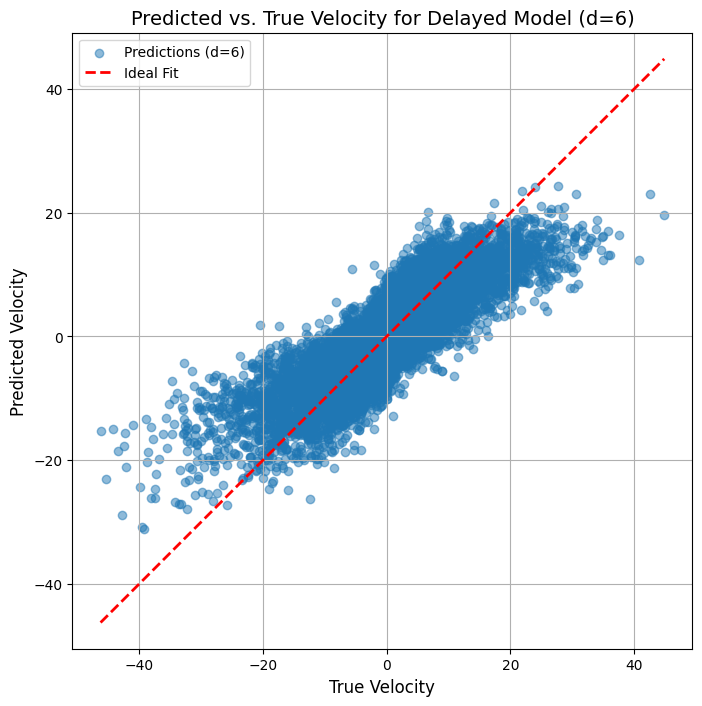

In [13]:
# TODO %% [markdown] ## Selecting the Optimal Delay via Model Order Selection
#
# In the previous example, we fixed `d=6`. We can now select the optimal delay
# using model order selection. Since we have a large number of data samples, it
# turns out that the optimal model order uses a very high delay. So to save on
# computation time, we will just do a simple train-test split. We won't do any
# k-fold cross-validation. %% [markdown] We will look at model orders up to
# `dmax=30`. Create a delayed dataset, `Xdly,ydly` using `create_dly_data` with
# `dly=dmax`. Split this data into training and test data as before, with a 2/3
# -1/3 split. %%
# TODO: Plot the predicted vs. true values
plt.figure(figsize=(8, 8))
plt.scatter(ydly_ts, yhat_dly, alpha=0.5, label=f'Predictions (d={d})')

# Add the ideal y=x line
min_val = min(np.min(ydly_ts), np.min(yhat_dly))
max_val = max(np.max(ydly_ts), np.max(yhat_dly))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit')

# Labeling
plt.xlabel("True Velocity", fontsize=12)
plt.ylabel("Predicted Velocity", fontsize=12)
plt.title(f"Predicted vs. True Velocity for Delayed Model (d={d})", fontsize=14)
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

## Selecting the Optimal Delay via Model Order Selection

In the previous example, we fixed `d=6`.  We can now select the optimal delay using model order selection.  Since we have a large number of data samples, it turns out that the optimal model order uses a very high delay.  
So to save on computation time, we will just do a simple train-test split. We won't do any k-fold cross-validation.

We will look at model orders up to `dmax=30`.  Create a delayed dataset, `Xdly,ydly` using `create_dly_data` with `dly=dmax`. Split this data into training and test data as before, with a 2/3 -1/3 split.

In [14]:
dmax = 30

# TODO
# Xdly, ydly = .. %% [markdown] Implement a loop to test different amounts of
# delay from 0 to `dmax`. For each delay, you should train on the train set and
# compute the average squared loss on the test set. Store these losses in an
# array `losses`.

# Create the delayed dataset using dmax
print(f"\nCreating a single, large delayed dataset with dmax={dmax}...")
X_mos, y_mos = create_dly_data(X, y, dmax)

# Create a single 2/3 - 1/3 train-test split for this large dataset
nt_mos = X_mos.shape[0]
indices_mos = np.random.permutation(nt_mos)
split_idx_mos = int(np.floor(2/3 * nt_mos))

train_indices_mos = indices_mos[:split_idx_mos]
test_indices_mos = indices_mos[split_idx_mos:]

X_mos_tr, y_mos_tr = X_mos[train_indices_mos,:], y_mos[train_indices_mos]
X_mos_ts, y_mos_ts = X_mos[test_indices_mos,:], y_mos[test_indices_mos]

print("Data is ready for model order selection.")
print(f"X_mos_tr shape: {X_mos_tr.shape}")
print(f"y_mos_tr shape: {y_mos_tr.shape}")
print(f"X_mos_ts shape: {X_mos_ts.shape}")
print(f"y_mos_ts shape: {y_mos_ts.shape}")


Creating a single, large delayed dataset with dmax=30...
Data is ready for model order selection.
X_mos_tr shape: (40872, 1612)
y_mos_tr shape: (40872,)
X_mos_ts shape: (20437, 1612)
y_mos_ts shape: (20437,)


Implement a loop to test different amounts of delay from 0 to `dmax`. For each delay, you should train on the train set and compute the average squared loss on the test set. Store these losses in an array `losses`.

**Important Note**: for different delay values you should be using a different **subset of columns** from the `Xdly` matrix you just created. To save time, you don't want to be re-creating a new test set for each model order you experiment with.

Your code could take a long time (several minutes) to run! This is a large data set and we are using many features in our multivariate regression. You might want to test/debug your code with a signficantly small value of `dmax` before doing a final run.

In [17]:
# losses = np.zeros(dmax)
# for i in range(0,dmax):
    # TODO
    # losses[i] =
# Get the number of original features (neurons)
nneuron = X.shape[1]
dmax = 30

# Initialize an array to store losses for d=0, 1, ..., 30 (31 total values)
losses = np.zeros(dmax + 1)

print(f"Testing delays from 0 to {dmax}...")

# Loop through each possible delay from 0 to 30 inclusive
for i in range(dmax + 1):
    # i represents the current delay value (d)
    # The number of columns needed is (d+1) * nneuron
    num_cols = (i + 1) * nneuron

    # Select the correct subset of features from the pre-split data
    X_tr_subset = X_mos_tr[:, :num_cols]
    X_ts_subset = X_mos_ts[:, :num_cols]

    # Fit the model on the training subset
    beta = fit_mult_linear(X_tr_subset, y_mos_tr)

    # Add intercept column to the test subset
    X_ts_subset_aug = np.concatenate((np.ones((X_ts_subset.shape[0], 1)), X_ts_subset), axis=1)

    # Make predictions and calculate the loss
    yhat = X_ts_subset_aug @ beta
    losses[i] = np.mean((y_mos_ts - yhat)**2)

    # Optional: Print progress
    if (i) % 5 == 0:
      print(f"  ... loss for d={i}: {losses[i]:.4f}")

print("Finished calculating losses for all delays.")

Testing delays from 0 to 30...
  ... loss for d=0: 57.1928
  ... loss for d=5: 56.2731
  ... loss for d=10: 55.8342
  ... loss for d=15: 55.7284
  ... loss for d=20: 55.1634
  ... loss for d=25: 44.0782
  ... loss for d=30: 16.4556
Finished calculating losses for all delays.


Which amount of delay lead to the best model fit? Plot losses as a function of `range(0,dmax)` to visualize how generalization of your model changes with increasing complexity


The optimal delay is d = 30
This resulted in a minimum average squared loss of: 16.4556


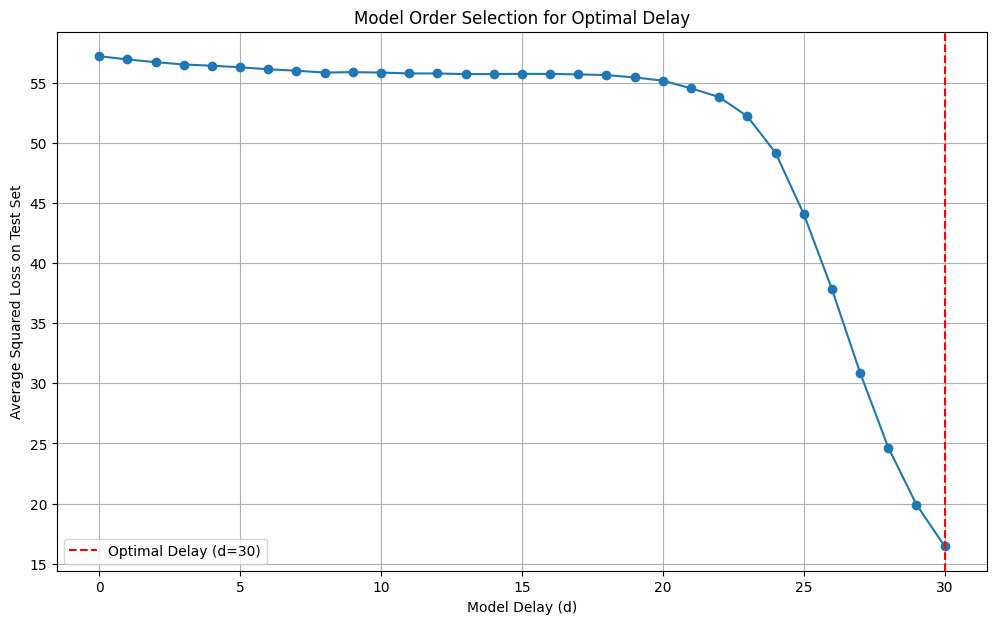

In [19]:
# TODO
# best_delay=
# Find the delay that resulted in the minimum loss
# Find the delay that resulted in the minimum loss
best_delay = np.argmin(losses)
min_loss = losses[best_delay]

print(f"\nThe optimal delay is d = {best_delay}")
print(f"This resulted in a minimum average squared loss of: {min_loss:.4f}")

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(range(dmax + 1), losses, marker='o')
plt.axvline(best_delay, color='r', linestyle='--', label=f'Optimal Delay (d={best_delay})')
plt.xlabel("Model Delay (d)")
plt.ylabel("Average Squared Loss on Test Set")
plt.title("Model Order Selection for Optimal Delay")
plt.grid(True)
plt.legend()
plt.show()